# Training simple neural networks on the MNIST dataset using keras

You can create a suitable conda environment to run this notebook using:

    conda create -n keras_demo python=3 tensorflow matplotlib ipykernel scikit-learn pandas
    
If you haven't got the latest cuda drivers, you may also need to specify `cudatoolkit=9.0` or similar.

### First some common imports...

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

### Set up TensorFlow in a friendly manner

In [2]:
import tensorflow.compat.v1 as tf

# if multiple GPUs, only use one of them 
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

# avoid hogging all the GPU memory
#config = tf.ConfigProto()
#config.gpu_options.allow_growth=True
#sess = tf.Session(config=config)

In [3]:
# check that we have the devices we expect available
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15679167924466090820]

### Import keras bits and pieces

In [4]:
# if you have a recent version of tensorflow, keras is included
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop

### We will use a standard demonstration data set: MNIST handwritten digits

In [5]:
# the data, split between train and test sets
(x_train, y_train), (x_valtest, y_valtest) = mnist.load_data()

In [6]:
# demo the effect of noisy data
#x_train = (x_train/5 + np.random.poisson(200, size=x_train.shape)).clip(0, 255)
#x_valtest = (x_valtest/5 + np.random.poisson(200, size=x_valtest.shape)).clip(0, 255)

In [7]:
# if we wanted to test our model on limited data,
# we could reduce the amount of training data like this...
idx = np.random.choice(len(x_train), size=len(x_train)//100)
x_train = x_train[idx]
y_train = y_train[idx]

If your data isn't split, or want a validation set, need to do split manually

In [8]:
from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(x_valtest, y_valtest, test_size=0.5)

In [9]:
x_train.shape, y_train.shape

((600, 28, 28), (600,))

In [10]:
x_test.shape, y_test.shape

((5000, 28, 28), (5000,))

In [11]:
x_val.shape, y_val.shape

((5000, 28, 28), (5000,))

### Take a look at the data

This is a very quick glance - you should carefully examine any new dataset

class = 0


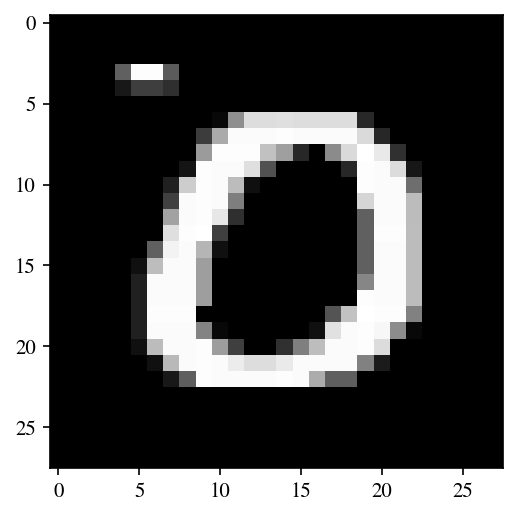

In [12]:
i = 3
plt.imshow(x_train[i], cmap='gray')
print('class =', y_train[i])

### Prepare the data

In [13]:
# convert class vectors to "one-hot" binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

In [14]:
y_train[i]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [15]:
def process_data(x):
    x = x.reshape(-1, 784)
    x = x.astype('float32')
    x /= 255
    return x

In [16]:
x_train = process_data(x_train)
x_test = process_data(x_test)
x_val = process_data(x_val)

In [17]:
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_val.shape[0], 'validation samples')

600 train samples
5000 test samples
5000 validation samples


## Fully-connected NN

### Construct the network

In [18]:
# a fairly small network for speed
fcmodel = Sequential()
fcmodel.add(Dense(32, activation='relu', input_shape=(784,)))
fcmodel.add(Dense(32, activation='relu'))
# could include dropout, regularisation, ...
fcmodel.add(Dense(num_classes, activation='softmax'))

In [19]:
fcmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


In [20]:
fcmodel.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])

### Train the network

In [21]:
batch_size = 32
epochs = 50

In [22]:
history = fcmodel.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=2,
                      validation_data=(x_test, y_test))

Train on 600 samples, validate on 5000 samples
Epoch 1/50
600/600 - 10s - loss: 2.0447 - accuracy: 0.3367 - val_loss: 1.7192 - val_accuracy: 0.4632
Epoch 2/50
600/600 - 2s - loss: 1.4603 - accuracy: 0.6500 - val_loss: 1.2558 - val_accuracy: 0.7298
Epoch 3/50
600/600 - 1s - loss: 1.0484 - accuracy: 0.7917 - val_loss: 0.9679 - val_accuracy: 0.7822
Epoch 4/50
600/600 - 1s - loss: 0.7924 - accuracy: 0.8267 - val_loss: 0.8085 - val_accuracy: 0.8014
Epoch 5/50
600/600 - 1s - loss: 0.6252 - accuracy: 0.8533 - val_loss: 0.7021 - val_accuracy: 0.8142
Epoch 6/50
600/600 - 1s - loss: 0.5199 - accuracy: 0.8767 - val_loss: 0.6619 - val_accuracy: 0.7920
Epoch 7/50
600/600 - 1s - loss: 0.4349 - accuracy: 0.9017 - val_loss: 0.5952 - val_accuracy: 0.8334
Epoch 8/50
600/600 - 1s - loss: 0.3749 - accuracy: 0.9017 - val_loss: 0.5594 - val_accuracy: 0.8308
Epoch 9/50
600/600 - 1s - loss: 0.3286 - accuracy: 0.9267 - val_loss: 0.5567 - val_accuracy: 0.8166
Epoch 10/50
600/600 - 1s - loss: 0.2818 - accuracy: 

In [23]:
score = fcmodel.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8875194945335388
Test accuracy: 0.849


In [24]:
# really we should not look at the score for this set of data
# until we have finished tuning our model
score = fcmodel.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8544167378340848
Test accuracy: 0.8642


In [25]:
def histplot(history):
    hist = pd.DataFrame(history.history)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    hist.plot(y=['loss', 'val_loss'], ax=ax1)
    min_loss = hist['val_loss'].min()
    ax1.hlines(min_loss, 0, len(hist), linestyle='dotted',
               label='min(val_loss) = {:.3f}'.format(min_loss))
    ax1.legend(loc='upper right')
    hist.plot(y=['accuracy', 'val_accuracy'], ax=ax2)
    max_acc = hist['val_accuracy'].max()
    ax2.hlines(max_acc, 0, len(hist), linestyle='dotted',
               label='max(val_acc) = {:.3f}'.format(max_acc))
    ax2.legend(loc='lower right', fontsize='large')

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

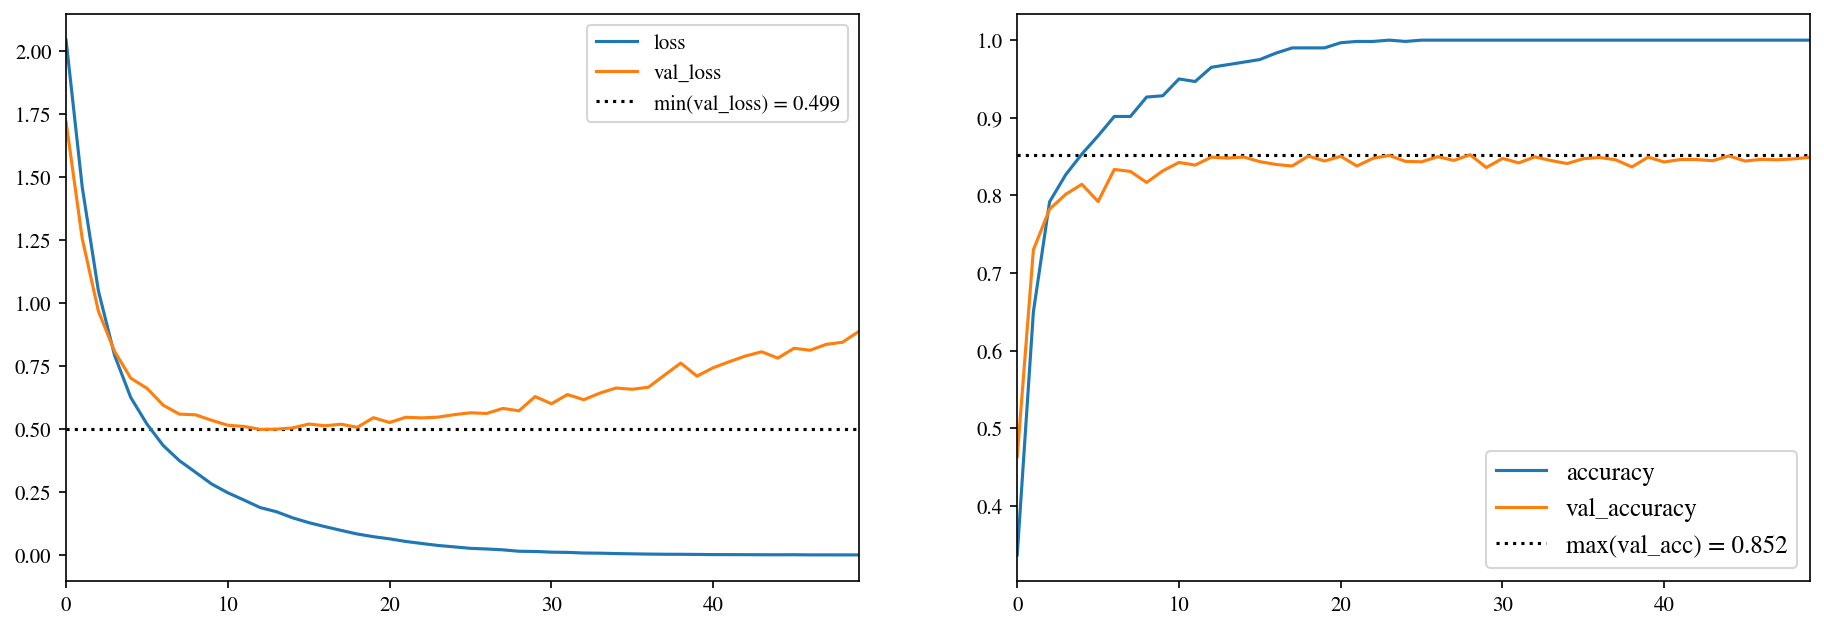

In [27]:
histplot(history)

## Convolutional Neural Network (CNN)

### Reshape the data

In [28]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

### Construct the network

In [29]:
# a fairly small network for speed
cnnmodel = Sequential()
cnnmodel.add(Conv2D(8, (3, 3), activation='relu', input_shape=(28, 28, 1)))
cnnmodel.add(MaxPooling2D((3, 3)))
cnnmodel.add(Conv2D(16, (3, 3), activation='relu'))
cnnmodel.add(MaxPooling2D((2, 2)))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(num_classes, activation='softmax'))
# could include dropout, regularisation, ...

In [30]:
cnnmodel.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])

In [31]:
cnnmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 16)          1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 144)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1450      
Total params: 2,698
Trainable params: 2,698
Non-trainable params: 0
____________________________________________________

In [32]:
# save weights for reinitialising below
cnnmodel.save_weights('/tmp/cnnmodel_init_weights.tf')

### Train the network

In [33]:
history = cnnmodel.fit(x_train, y_train,
                       batch_size=batch_size, 
                       epochs=3*epochs,
                       verbose=2,
                       validation_data=(x_test, y_test))

Train on 600 samples, validate on 5000 samples
Epoch 1/150
600/600 - 4s - loss: 2.2658 - accuracy: 0.1417 - val_loss: 2.1815 - val_accuracy: 0.2240
Epoch 2/150
600/600 - 1s - loss: 2.1168 - accuracy: 0.3267 - val_loss: 2.0354 - val_accuracy: 0.4274
Epoch 3/150
600/600 - 1s - loss: 1.9231 - accuracy: 0.4700 - val_loss: 1.7967 - val_accuracy: 0.6068
Epoch 4/150
600/600 - 1s - loss: 1.6592 - accuracy: 0.5967 - val_loss: 1.5370 - val_accuracy: 0.6406
Epoch 5/150
600/600 - 1s - loss: 1.3894 - accuracy: 0.6767 - val_loss: 1.2649 - val_accuracy: 0.7072
Epoch 6/150
600/600 - 1s - loss: 1.1399 - accuracy: 0.7150 - val_loss: 1.0489 - val_accuracy: 0.7512
Epoch 7/150
600/600 - 1s - loss: 0.9550 - accuracy: 0.7383 - val_loss: 0.8885 - val_accuracy: 0.7736
Epoch 8/150
600/600 - 1s - loss: 0.8134 - accuracy: 0.7750 - val_loss: 0.7674 - val_accuracy: 0.7994
Epoch 9/150
600/600 - 1s - loss: 0.7061 - accuracy: 0.8017 - val_loss: 0.6893 - val_accuracy: 0.8026
Epoch 10/150
600/600 - 1s - loss: 0.6289 - a

Epoch 81/150
600/600 - 1s - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.3537 - val_accuracy: 0.9102
Epoch 82/150
600/600 - 1s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.3051 - val_accuracy: 0.9242
Epoch 83/150
600/600 - 1s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.3426 - val_accuracy: 0.9172
Epoch 84/150
600/600 - 1s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.3244 - val_accuracy: 0.9208
Epoch 85/150
600/600 - 1s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.3346 - val_accuracy: 0.9202
Epoch 86/150
600/600 - 1s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.3552 - val_accuracy: 0.9136
Epoch 87/150
600/600 - 1s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.3512 - val_accuracy: 0.9148
Epoch 88/150
600/600 - 1s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.3210 - val_accuracy: 0.9232
Epoch 89/150
600/600 - 1s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.3394 - val_accuracy: 0.9220
Epoch 90/150
600/600 - 1s - loss: 0.0040 - accuracy: 0.9983 - val_loss: 0.3605 - v

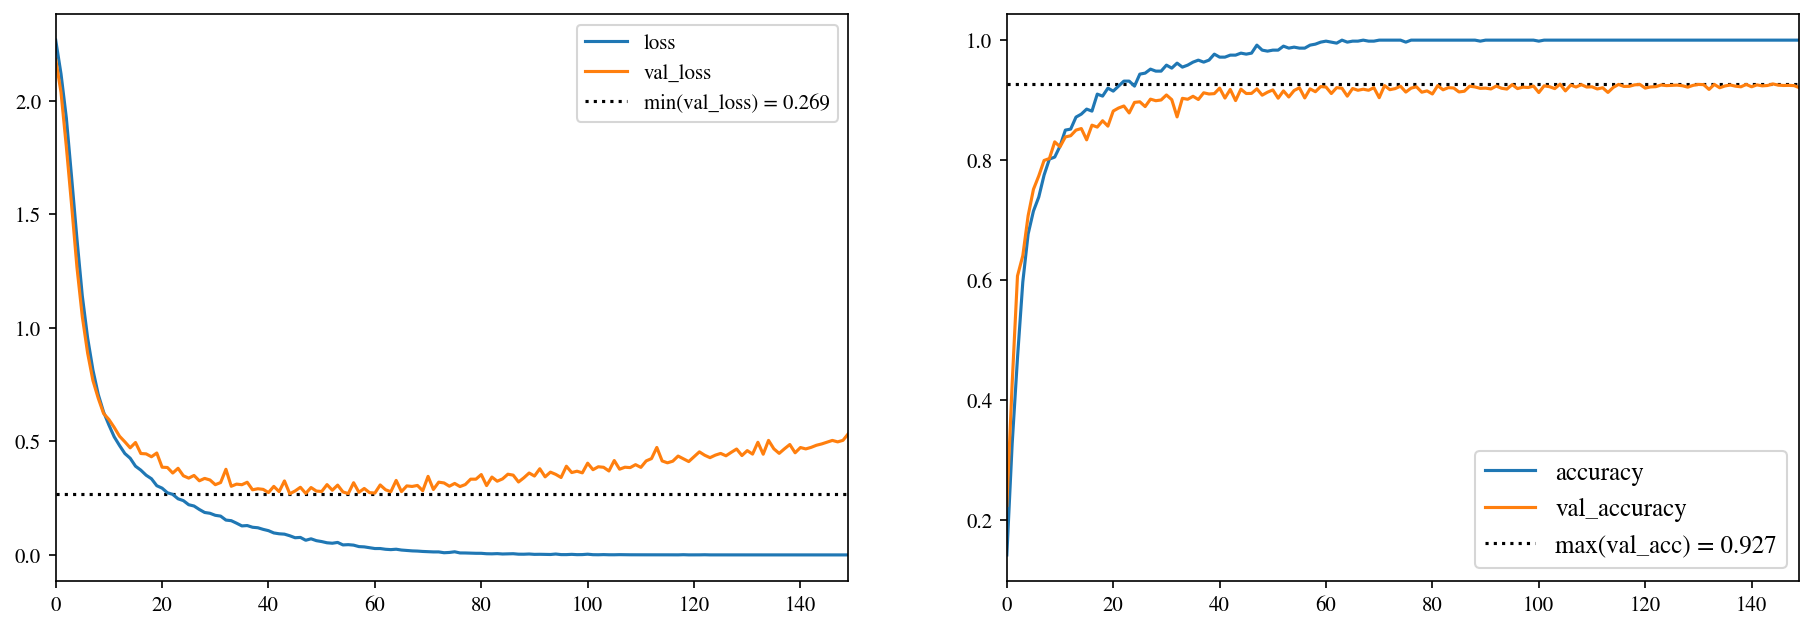

In [34]:
histplot(history)

## Online data augmentation

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=20.0,
    zoom_range=0.05)

#datagen.fit(x_train)  # only required if normalizing

In [36]:
gen = datagen.flow(x_train, y_train, batch_size=1)

label = 6


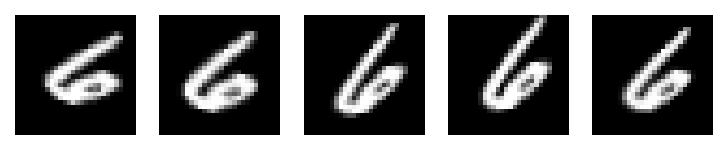

In [37]:
# run this several times to see more augmented examples
i = 3
fig, axarr = plt.subplots(1, 5)
for ax in axarr:
    img = gen[i][0][0, : , :, 0]
    ax.imshow(img, cmap='gray');
    ax.axis('off')
print('label =', gen[i][1][0].argmax())

In [38]:
# Reinitialise model
cnnmodel.load_weights('/tmp/cnnmodel_init_weights.tf')

In [39]:
cnnmodel.compile(loss='categorical_crossentropy',
                 optimizer=RMSprop(),
                 metrics=['accuracy'])

In [40]:
# fits the model on batches with real-time data augmentation:
# the accuracy continues to (slowly) rise, due to the augmentation
history = cnnmodel.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), 
                                 epochs=3*epochs,
                                 verbose=2,
                                 validation_data=(x_test, y_test))

Epoch 1/150
19/19 - 19s - loss: 2.2727 - accuracy: 0.1500 - val_loss: 2.2073 - val_accuracy: 0.2996
Epoch 2/150
19/19 - 17s - loss: 2.1751 - accuracy: 0.3283 - val_loss: 2.0730 - val_accuracy: 0.4066
Epoch 3/150
19/19 - 19s - loss: 2.0390 - accuracy: 0.4083 - val_loss: 1.8911 - val_accuracy: 0.4846
Epoch 4/150
19/19 - 18s - loss: 1.8778 - accuracy: 0.4367 - val_loss: 1.6802 - val_accuracy: 0.5748
Epoch 5/150
19/19 - 18s - loss: 1.6961 - accuracy: 0.5417 - val_loss: 1.4591 - val_accuracy: 0.6430
Epoch 6/150
19/19 - 20s - loss: 1.5005 - accuracy: 0.5883 - val_loss: 1.2428 - val_accuracy: 0.7024
Epoch 7/150
19/19 - 16s - loss: 1.2996 - accuracy: 0.6550 - val_loss: 1.0704 - val_accuracy: 0.7294
Epoch 8/150
19/19 - 25s - loss: 1.1929 - accuracy: 0.6800 - val_loss: 0.9167 - val_accuracy: 0.7724
Epoch 9/150
19/19 - 21s - loss: 1.0909 - accuracy: 0.6767 - val_loss: 0.8186 - val_accuracy: 0.7862
Epoch 10/150
19/19 - 24s - loss: 0.9513 - accuracy: 0.7217 - val_loss: 0.7440 - val_accuracy: 0.7868

Epoch 83/150
19/19 - 17s - loss: 0.2061 - accuracy: 0.9417 - val_loss: 0.1656 - val_accuracy: 0.9448
Epoch 84/150
19/19 - 18s - loss: 0.1860 - accuracy: 0.9500 - val_loss: 0.1712 - val_accuracy: 0.9420
Epoch 85/150
19/19 - 22s - loss: 0.1717 - accuracy: 0.9450 - val_loss: 0.1672 - val_accuracy: 0.9438
Epoch 86/150
19/19 - 21s - loss: 0.1933 - accuracy: 0.9450 - val_loss: 0.1664 - val_accuracy: 0.9450
Epoch 87/150
19/19 - 24s - loss: 0.1717 - accuracy: 0.9467 - val_loss: 0.1644 - val_accuracy: 0.9452
Epoch 88/150
19/19 - 21s - loss: 0.1671 - accuracy: 0.9383 - val_loss: 0.1694 - val_accuracy: 0.9444
Epoch 89/150
19/19 - 18s - loss: 0.1579 - accuracy: 0.9483 - val_loss: 0.1736 - val_accuracy: 0.9434
Epoch 90/150
19/19 - 21s - loss: 0.1232 - accuracy: 0.9617 - val_loss: 0.1661 - val_accuracy: 0.9464
Epoch 91/150
19/19 - 24s - loss: 0.1684 - accuracy: 0.9483 - val_loss: 0.1701 - val_accuracy: 0.9440
Epoch 92/150
19/19 - 20s - loss: 0.1684 - accuracy: 0.9433 - val_loss: 0.1626 - val_accurac

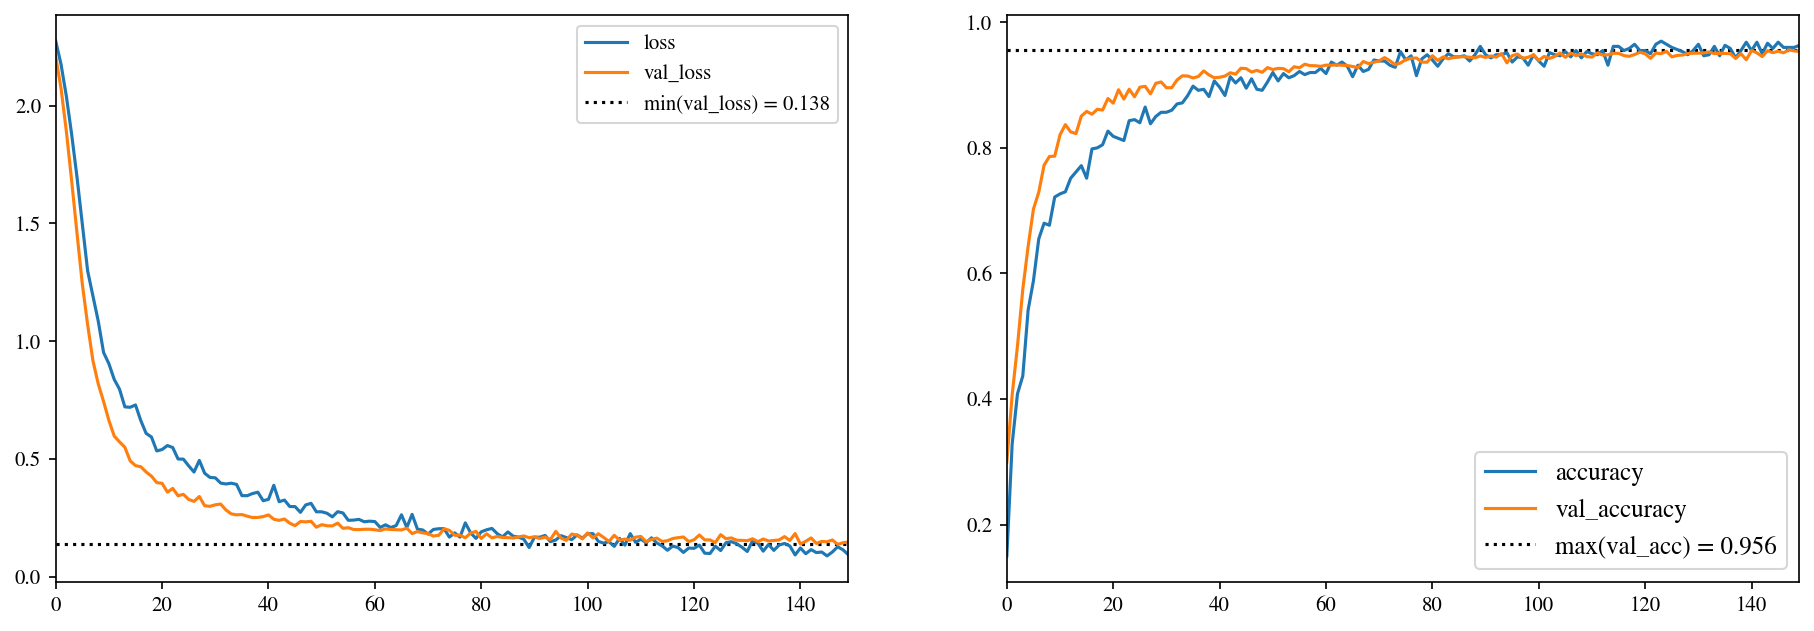

In [41]:
histplot(history)

Data augmentation reduced number of misclassifications by half.